# PSST - CNN with Sequence 2 Sequance (Encoder - decoder)

## 01 - Notbook definitions (hide warnings)

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

## 02 - Mount the drive for files save and import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 03 - Set the correct packages (re run notobook after install)

In [ ]:
!pip install -U seaborn==0.9.0
!pip install -U pandas==0.25
!pip install -U tensorflow==1.5


Requirement already up-to-date: seaborn==0.9.0 in /usr/local/lib/python3.6/dist-packages (0.9.0)
Requirement already up-to-date: pandas==0.25 in /usr/local/lib/python3.6/dist-packages (0.25.0)
Requirement already up-to-date: tensorflow==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0)


## 04 - Set the folders paths

In [ ]:
BASE_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/'

PLOTS_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/plots/'
DUMPS_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/dumps/'
DATA_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/data/'
CHECK_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/checkpoints/'

IMAGES_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/images/'


## 05 - Import the packages

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.set_random_seed(1234)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

## 06 - Load the dataset

In [ ]:
df = pd.read_csv(DATA_PATH +'GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


## 07 - Normalize the scale

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.112708
1,0.090008
2,0.089628
3,0.160459
4,0.188066


## 09 - Set the training and test set


1. Train dataset from starting timestamp until last 30 days
2. Test dataset from last 30 days until end of the

Forecasting based on last 30 days,and  repeat the experiment for 10 times.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

## 10 - Setup the model

In [ ]:
def encoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(
        inp,
        [
            [0, 0],
            [(filter_size[0] - 1) // 2, (filter_size[0] - 1) // 2],
            [0, 0],
            [0, 0],
        ],
    )
    conv = tf.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def decoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(inp, [[0, 0], [filter_size[0] - 1, 0], [0, 0], [0, 0]])
    conv = tf.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def glu(x):
    return tf.multiply(
        x[:, :, : tf.shape(x)[2] // 2],
        tf.sigmoid(x[:, :, tf.shape(x)[2] // 2 :]),
    )


def layer(inp, conv_block, kernel_width, n_hidden, residual = None):
    z = conv_block(inp, n_hidden, (kernel_width, 1))
    return glu(z) + (residual if residual is not None else 0)

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.layers.dense(self.X, size_layer)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            z = layer(
                encoder_embedded,
                encoder_block,
                kernel_size,
                size_layer * 2,
                encoder_embedded,
            )
            z = tf.nn.dropout(z, keep_prob = dropout)
            encoder_embedded = z

        encoder_output, output_memory = z, z + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            attn_res = h = layer(
                encoder_embedded,
                decoder_block,
                kernel_size,
                size_layer * 2,
                residual = tf.zeros_like(encoder_embedded),
            )
            C = []
            for j in range(n_attn_heads):
                h_ = tf.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, keep_prob = dropout)
            encoder_embedded = h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

## 11 - Set the hyperparameters

In [ ]:
num_layers = 1
size_layer = 128
timestamp = test_size
epoch = 300
dropout_rate = 0.7
future_day = test_size
learning_rate = 1e-3

## 12 - Set the training procedure 

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], 
        dropout = dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
            )        
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 300/300 [00:36<00:00,  8.21it/s, acc=97, cost=0.00199]


simulation 2


train loop: 100%|██████████| 300/300 [00:36<00:00,  8.27it/s, acc=96.5, cost=0.00251]


simulation 3


train loop: 100%|██████████| 300/300 [00:36<00:00,  8.16it/s, acc=95.9, cost=0.00396]


simulation 4


train loop: 100%|██████████| 300/300 [00:36<00:00,  8.17it/s, acc=96.1, cost=0.00323]


simulation 5


train loop: 100%|██████████| 300/300 [00:41<00:00,  7.25it/s, acc=97.9, cost=0.000991]


simulation 6


train loop: 100%|██████████| 300/300 [00:36<00:00,  8.12it/s, acc=95.2, cost=0.00512]


simulation 7


train loop: 100%|██████████| 300/300 [00:37<00:00,  8.08it/s, acc=95.6, cost=0.00412]


simulation 8


train loop: 100%|██████████| 300/300 [00:37<00:00,  8.09it/s, acc=96.5, cost=0.00343]


simulation 9


train loop: 100%|██████████| 300/300 [00:36<00:00,  8.24it/s, acc=96.5, cost=0.00256]


simulation 10


train loop: 100%|██████████| 300/300 [00:36<00:00,  8.16it/s, acc=96.1, cost=0.0032]


## 13 - Compute the performance

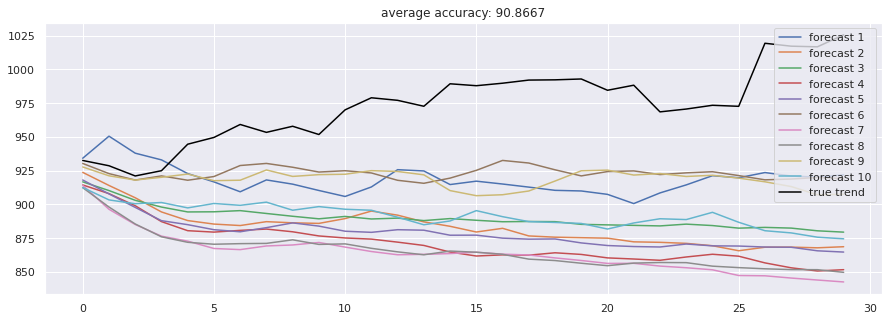

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()